In [1]:
import geopandas
import pandas as pd
import numpy as np
import datetime
import networkx as nx
from collections import Counter
from shapely.geometry import Point
from collections import defaultdict
from matplotlib import colors
import matplotlib.pyplot as plt
import pytz
from PIL import Image
import matplotlib

matplotlib.rcParams.update({'font.size': 12, 'font.style': 'normal', 'font.family':'serif'})

In [2]:
#functions that we need to compute the spatial uncertainty

def euclidean(coord1, coord2):
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    d = np.sqrt((lat1-lat2)**2 + (lon1-lon2)**2)
    return d

def spatial_uncertainty(location_list):
    
    c = Counter(location_list)
    l = c.most_common()
    h,p = l[0]
    s=0
    for i in l[1:]:
        h1,p1 = i
        s += ((p1/p))*(euclidean(h,h1)/2) 
        
    return s

# Data coupling

In this notebook, we will see how to couple our sample of CDRs data with a fine-grained socioeconomic map obtained from census data, in order to infer the socioeconomic status of mobile phone users and to obtain a geolocated socioeconomic network.

### 1. Socioeconomic map

We have downloaded two datasets from the French National Institute of Statistics (INSEE), that you can find in the ./data folder:

 - BASE_TD_FILO_DISP_IRIS_2014.xls: this is an Excel file that gives us multiple SES indicators of geographical units called ISIS. In particular, we will use the Median Income indicator. From the website of the INSEE: "In order to prepare for the dissemination of the 1999 population census, INSEE developed a system for dividing the country into units of equal size, known as IRIS2000. In French, IRIS is an acronym of ‘aggregated units for statistical information’, and the 2000 refers to the target size of 2000 residents per basic unit". The dataset can be downloaded here: https://www.insee.fr/fr/statistiques/3288151/
 - CONTOURS-IRIS_D075.shp: this is a standard shapefile with the shapes of the IRIS unit located in the Paris area. The IRIS shapefiles of all the French Départments can be found here: https://geoservices.ign.fr/documentation/diffusion/telechargement-donnees-libres.html#contoursiris
 
The first thing to do is to couple these two datasets together. Let's open the Excel data:

In [3]:
ses_df = pd.read_excel('./data/BASE_TD_FILO_DISP_IRIS_2014.xls', skiprows=[0,1,2,3,5])
ses_df.head(2)

,IRIS,Libellé de l'IRIS,Commune ou ARM,Libellé commune ou ARM,Taux de pauvreté au seuil de 60 % (%),1er quartile (€),Médiane (€),3e quartile (€),Écart interquartile rapporté à la médiane,1er décile (€),...,Part des revenus d'activités salariées (%),Part des revenus d'activités non salariées (%),"Part des pensions, retraites et rentes (%)",Part des revenus du patrimoine et autres revenus (%),Part de l'ensemble des prestations sociales (%),dont part des prestations familiales (%),dont part des minima sociaux (%),dont part des prestations logement (%),Part des impôts (%),Note de précaution
0,010040101,Les Perouses-Triangle d'Activite,01004,Ambérieu-en-Bugey,21.976356,12736.500000,18213.333333,24129.000000,0.625503,9701.500000,...,66.2,1.9,29.4,8.4,8.1,3.1,2.8,2.2,-14.0,0
1,010040102,Longeray-Gare,01004,Ambérieu-en-Bugey,23.787753,12383.448276,16777.777778,22245.714286,0.587817,9577.894737,...,65.9,1.6,27.5,7.9,10.1,3.5,3.3,3.3,-13.0,0


And the shapefile:

In [4]:
gdf = geopandas.read_file('./data/CONTOURS-IRIS_D075.shp')
gdf.head()

,DEPCOM,NOM_COM,IRIS,DCOMIRIS,NOM_IRIS,TYP_IRIS,geometry
0,75101,Paris 1er Arrondissement,0204,751010204,Les Halles 4,H,"POLYGON ((652285.810 6862819.570, 652245.570 6..."
1,75101,Paris 1er Arrondissement,0206,751010206,Les Halles 6,A,"POLYGON ((651617.700 6862947.100, 651633.050 6..."
2,75101,Paris 1er Arrondissement,0101,751010101,Saint-Germain l'Auxerrois 1,H,"POLYGON ((652186.300 6862282.900, 652146.790 6..."
3,75101,Paris 1er Arrondissement,0202,751010202,Les Halles 2,H,"POLYGON ((651540.000 6862651.000, 651556.100 6..."
4,75101,Paris 1er Arrondissement,0102,751010102,Saint-Germain l'Auxerrois 2,A,"POLYGON ((651923.060 6861773.040, 651925.700 6..."


The IRIS code is what we need to couple the two together. We notice that they have different names in the two datasets. We will rename the column in one of the two in order to be able to do a simple merge. Then we'll save only the columns that we need (in particular the median income):

In [13]:
ses_df.rename(columns={'IRIS':'DCOMIRIS', 'Médiane (€)':'Median'}, inplace=True)
iris_gdf = geopandas.GeoDataFrame(pd.merge(gdf, ses_df, on='DCOMIRIS'), crs=gdf.crs)              #merge and turn into gdf
iris_gdf = iris_gdf[['DCOMIRIS', 'NOM_IRIS','Median','geometry']]                    
iris_gdf.head()

,DCOMIRIS,NOM_IRIS,Median,geometry
0,751010204,Les Halles 4,32951.428571,"POLYGON ((652285.810 6862819.570, 652245.570 6..."
1,751010202,Les Halles 2,34187.333333,"POLYGON ((651540.000 6862651.000, 651556.100 6..."
2,751010203,Les Halles 3,30669.333333,"POLYGON ((651540.000 6862651.000, 651519.000 6..."
3,751010301,Palais Royal 1,34172.333333,"POLYGON ((650990.000 6862972.000, 651075.000 6..."
4,751010201,Les Halles 1,27777.000000,"POLYGON ((652285.810 6862819.570, 652375.500 6..."


Let's plot the shapefile alone, and the merged dataset (coloring IRIS units according to their median income):

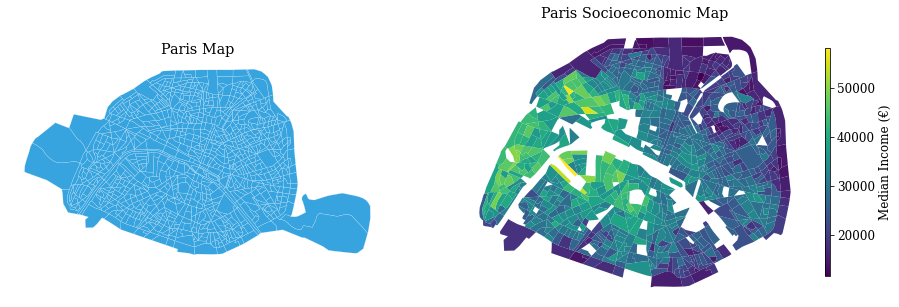

In [6]:


fig, ax = plt.subplots(1,2,figsize=(15,6))
iris_gdf.plot(column='Median', ax = ax[1], 
              legend=True, legend_kwds = {
                  'fraction':0.05,'shrink':0.7, 'aspect':50,
                  'label':'Median Income (€)'
              }
             )
gdf.plot(ax=ax[0],color= '#058ED9', alpha=0.8, edgecolor='w', lw=0.2)
ax[0].set_title('Paris Map')
ax[1].set_title('Paris Socioeconomic Map')
for a in ax:
    a.axis('off')

We notice that we can not obtain the SE indicator for all the IRIS units. In fact, some are in the river Seine (clearly visible), some are in parks, some other might not be available for some other reasons.

### 2. CDRs and Tower location

Here and in the next section we'll do exactly the same steps that we've already done in class 5 to infer the home location of users.

In [14]:
#read CDRs and save in an array

cet = pytz.timezone('Europe/Paris') 

cdr_list = []

with open('./data/CDR_sample.dat','r') as f:
    for line in f:
        l = line.split('\n')[0]
        el = l.split('|') 
        date = el[0]          
        time = el[1]
        dt = datetime.datetime.strptime(date+time, '%Y%m%d%H%M%S')
        caller = int(el[2])
        callee = int(el[3])
        tower = int(el[4])
        etype = el[5]
        cdr_list.append([cet.localize(dt).timestamp(), caller, callee, tower])

#array with datetime timestamp, caller, callee, tower
cdr_ar = np.array(cdr_list, dtype=int)
cdr_ar[:5]

array([[1238194933,      29577,      12651,          9],
       [1238194887,      39808,       3745,        328],
       [1238194934,      33910,      42874,        342],
       [1238194936,      38991,      24501,        328],
       [1238194931,      54346,      18711,        180]])

Now let's put the cell towers on the socioeconomic map, sizing them according to their activity:

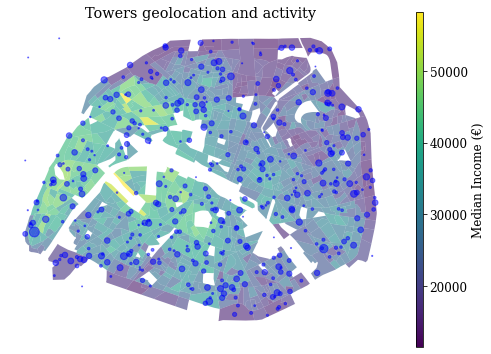

In [17]:

#read file with coords

tower_coords = {}
with open('./data/towers_geolocation.txt', 'r') as f:
    for line in f:
        k = line.split('\n')[0]
        k = k.split('\t')
        tower_coords[int(k[0])] = (float(k[1]), float(k[2]))

#count activity of towers
tower_count = Counter(cdr_ar[:,-1])
        
#create gdf with ids, geometry and activity
geom = []
ids = []
act = []
for i in tower_coords:
    ids.append(i)
    geom.append(Point(tower_coords[i]))
    act.append(tower_count[i])
    
tower_gdf = geopandas.GeoDataFrame({'id': ids,'activity': act,
                              'geometry': geom}, crs = 'epsg:4326')
    
fig, ax = plt.subplots(1,1,figsize=(7,7))

#change projection to the one of the socioeconomic map
tower_gdf.to_crs(iris_gdf.crs, inplace=True)

iris_gdf.plot(ax=ax, alpha=0.6, column = 'Median',
                          legend=True, legend_kwds = {
                  'fraction':0.05,'shrink':0.7, 'aspect':50,
                  'label':'Median Income (€)'
              })

#new column with square root of activity, for a better visualization
tower_gdf['size_activity'] = tower_gdf.activity.apply(np.sqrt)   
tower_gdf.sort_values('activity', ascending=False).plot(ax=ax, marker='o', markersize='size_activity', color='b', alpha=0.5,
                                                       edgecolor='b')
ax.set_title('Towers geolocation and activity')
ax.axis('off')
fig.tight_layout()

We can see that most of the towers fall in an IRIS unit: this is a good news for us as we will be able to infer the socioeconomic status of all the users whose home falls in one of these unit. Looking at the figure above we can imagine that they will be the majority.

### 3. Home Location Inference

Same steps and filters already seen.

In [18]:
#only night activity for home location inference
hour_map = lambda x: datetime.datetime.fromtimestamp(x, tz=cet).hour
df = pd.DataFrame(cdr_ar, columns=['datetime', 'caller', 'callee', 'tower'])
df['hour'] = df.datetime.apply(hour_map)
night_df = df[(df.hour >= 22 ) | (df.hour < 7) ]
night_cdr = cdr_ar[night_df.index]

#list of towers visited by each user
user_towers = defaultdict(list)
for i in night_cdr:
    user = i[1]
    tower = i[3]
    user_towers[user].append(tower)
    
#filter on the minimum number of events
min_val = 10
good_users = [i for i in user_towers if len(user_towers[i]) >=min_val]

tup = list(zip(tower_gdf.id, tower_gdf.geometry))
tower_loc = {i[0]: (i[1].x, i[1].y) for i in tup}
user_trajectory = {}
for i in good_users:
    user_trajectory[i] = [tower_loc[j] for j in user_towers[i]]
    
#filter on spatial uncertainty
su = {i: spatial_uncertainty(user_trajectory[i]) for i in user_trajectory}
good_users1 = [i for i in good_users if su[i] <=5000]

We can now infer the home location to each user (the most frequent location), and plot all home locations on the socioeconomic map:

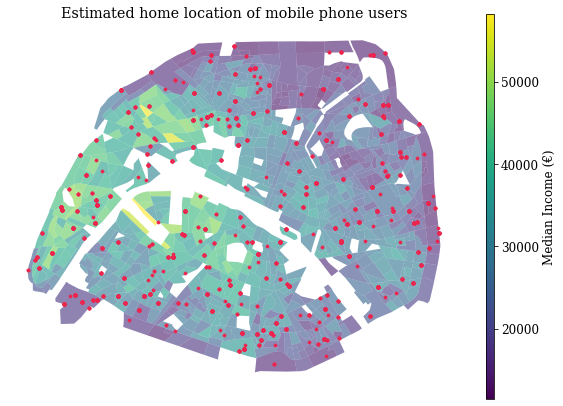

In [19]:


#home = most frequent location
user_home = {}
for i in good_users1:
    count = Counter(user_towers[i])
    user_home[i] = count.most_common()[0][0]
    
#create home gdf
geom = []
ids = []
users = []
for i in user_home:
    geom.append(Point(tower_loc[user_home[i]]))
    ids.append(user_home[i])
    users.append(i)

home_gdf = geopandas.GeoDataFrame({'geometry':geom, 'tower':ids, 'user':users}, crs=iris_gdf.crs)

fig, ax = plt.subplots(1,1,figsize=(8,8))
iris_gdf.plot(ax=ax, alpha=0.6, column = 'Median',
                          legend=True, legend_kwds = {
                  'fraction':0.05,'shrink':0.7, 'aspect':50,
                  'label':'Median Income (€)'
              })
home_gdf.plot(ax=ax, color='#ed254e', linewidth=0.2, markersize=12,)
ax.axis('off')
ax.set_title('Estimated home location of mobile phone users')
fig.tight_layout()

It looks like most (if not all) of them fall in an IRIS unit, and those users are the one for whom we can infer the SES.

### 4. SES inference and SE network

In order to do the SES inference, we do a very simple procedure: we assign to each user the socioeconomic index of the IRIS unit where his/her home location falls. This can be done automatically with geopandas, using a spatial join:

In [22]:
#spatial join: towers within IRIS units
sjoin_gdf = geopandas.sjoin(home_gdf, iris_gdf, how='inner', predicate='within')
sjoin_gdf.head()

,geometry,tower,user,index_right,DCOMIRIS,NOM_IRIS,Median
0,POINT (657117.073 6861498.601),36,29577,858,751208008,Charonne 8,15398.4
87,POINT (657117.073 6861498.601),36,50516,858,751208008,Charonne 8,15398.4
130,POINT (657117.073 6861498.601),36,40960,858,751208008,Charonne 8,15398.4
274,POINT (657117.073 6861498.601),36,55735,858,751208008,Charonne 8,15398.4
282,POINT (657103.632 6861665.497),107,47205,858,751208008,Charonne 8,15398.4


We can see how in the sjoin_gdf to each user is now associated a Median Income value, that we'll consider as SES. Almost all of the home located users have now a SES:

In [23]:
print('Fraction of home located users with infered SES:', round(len(sjoin_gdf) / len(home_gdf), 3))

Fraction of home located users with infered SES: 0.997


We are now ready to build our geolocated socioeconomic network:

In [24]:
#assign SES to towers (it will be useful later)
tower_ses = {}
for i,j in zip(sjoin_gdf.tower, sjoin_gdf.Median):
    tower_ses[i] = j
    
good_users2 = sjoin_gdf.user.values    #only users with SES

filt = cdr_ar[(np.isin(cdr_ar[:,1], good_users2)) &    # CDRs of users with SES (both callers and callees)
              (np.isin(cdr_ar[:,2], good_users2)) ]    
tup = filt[:,1:3]                                                         #edge list
home_tup = [tuple(sorted((user_home[i], user_home[j]))) for i,j in tup]   #location edge list 
home_tup[:5]

[(22, 487), (50, 225), (312, 388), (312, 388), (52, 404)]

Finally, we can create the network and visualize it: we color the nodes according to the socioeconomic status, and we size them according to their degree:

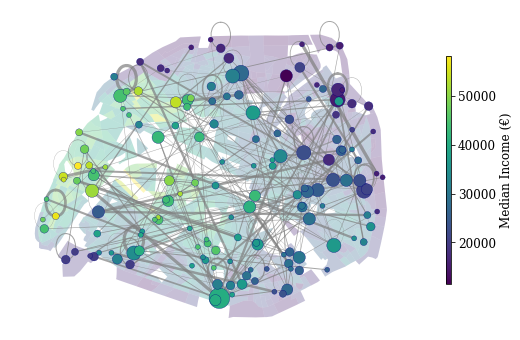

In [25]:

#weight of edges
count = Counter(home_tup)
weighted_el = [(i[0],i[1],count[i]) for i in count]

#create network
g = nx.Graph()
g.add_weighted_edges_from(weighted_el)
deg = {i: g.degree(i) for i in g.nodes()}
weight = nx.get_edge_attributes(g, 'weight')

fig, ax = plt.subplots(1,1,figsize=(10,6))

iris_gdf.plot(ax=ax, alpha=0.3, column = 'Median',
                          legend=True, legend_kwds = {
                  'fraction':0.015,'shrink':0.7, 'aspect':50,
                  'label':'Median Income (€)'
              })

nodes_deg = sorted([(i, g.degree(i) )for i in g.nodes()], key=lambda x:x[1], reverse=True)
nodes = [i[0] for i in nodes_deg]
edges = list(g.edges())
nx.draw_networkx_nodes(g, nodelist=nodes, pos = tower_loc, ax = ax, node_color=[tower_ses[i] for i in nodes],
                       edgecolors='navy', linewidths=0.3,
                       node_size=[g.degree(i)*25 for i in nodes])
nx.draw_networkx_edges(g, pos = tower_loc, edgelist=edges, width = [np.sqrt(weight[i]/10) for i in edges], 
                       edge_color='grey', alpha=0.7)

ax.axis('off');

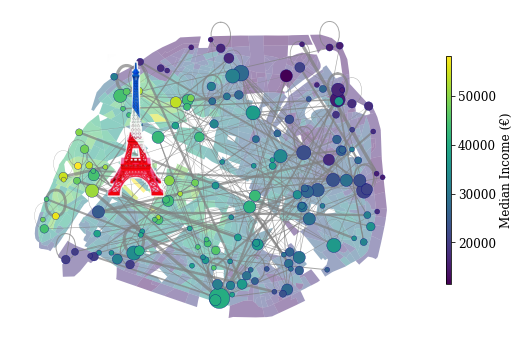

In [27]:

#geolocated socioeconomic network with tour eiffel!

#read image and turn white pixels to transparent
img = Image.open('./data/tour.png')
img = img.convert("RGBA")
newdata = []
for i in img.getdata():
    if i[:3] == (255, 255, 255):
        newdata.append((255,255,255,0))
    else:
        newdata.append((i[0],i[1],i[2],10000))
img.putdata(newdata)

fig, ax = plt.subplots(1,1,figsize=(10,6))

iris_gdf.plot(ax=ax, alpha=0.5, column = 'Median',
                          legend=True, legend_kwds = {
                  'fraction':0.015,'shrink':0.7, 'aspect':50,
                  'label':'Median Income (€)'
              })

nx.draw_networkx_nodes(g, nodelist=nodes, pos = tower_loc, ax = ax, node_color=[tower_ses[i] for i in nodes],
                       edgecolors='navy', linewidths=0.3,
                       node_size=[g.degree(i)*25 for i in nodes])
nx.draw_networkx_edges(g, pos = tower_loc, edgelist=edges, width = [np.sqrt(weight[i]/10) for i in edges], 
                       edge_color='grey', alpha=0.7)

ax.axis('off')
newax = fig.add_axes([0.28,0.42,0.35,0.35])
newax.imshow(img)
newax.axis('off');